In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import jv, jvp, yv, iv
from scipy.optimize import root_scalar
plt.rcParams.update({'font.size': 18})
# %matplotlib qt

global kp, cP, cS, radius

def Odaka_Usami_matrix1978(omega, p, cl, ct, R):
    '''
    Equation 2.1 and 2.2 of Odaka and Usami (1978).
    "Some properties of spheroidal Modes of a Homogeneous Elastic sphere with Special 
    Reference to Radial Dependence of Displacement. Journal of Computational Physics, 29, 431-445, 1978
    omega = angular frequency
    p = angular wavenumber
    cl = longitudinal wave velocity of material
    ct = shear wave velocity of material
    '''
    # re-scaling for numerical convenience
    R = R*1000
    cl = cl/1000
    ct = ct/1000
    omega = omega/1e6
    # Code starts
    kl = omega/cl
    kt = omega/ct
    x = kl*R
    y = kt*R
    # Matrix form
    a = np.sqrt(2)*np.sqrt(np.pi)*(np.sqrt(2)*np.sqrt(np.pi)*(-p*jv(p, y) + y*jv(p - 1, y) -3*jv(p, y)/2)*np.sqrt(1/y)/R**2 + np.sqrt(2)*np.sqrt(np.pi)*(-2*y*jv(p - 1, y) + (2*p + 1)*jv(p, y) - (2*y**2 -(2*p - 1)*(2*p + 1))*jv(p, y)/4)*np.sqrt(1/y)/R**2)
    b = 2*np.pi*(p - 1/2)*(p + 1/2)*(-p*jv(p, x) + x*jv(p - 1, x) - 3*jv(p, x)/2)
    c = (-p*jv(p, y) + y*jv(p - 1, y) - 3*jv(p, y)/2)*np.sqrt(1/x)*np.sqrt(1/y)/R**4
    d = (-2*x*jv(p - 1, x) + (2*p + 1)*jv(p, x) - (2*y**2 - (2*p - 1)*(2*p + 1))*jv(p, x)/4)*np.sqrt(1/x)/R**2    
    M = np.array([[a, b], [c, d]])
    return M


def Sato_Usami_matrix1962(omega, p, cl, ct, R):
    '''
    Basic Study on the Oscillation of Homogeneous Elastic Sphere-Part I: Frequency of the Free Oscillations 
    Equation 2.2. 1962
    omega = angular frequency
    p = angular wavenumber
    cl = longitudinal wave velocity of material
    ct = shear wave velocity of material
    '''
    # re-scaling for numerical convenience
    R = R*1000
    cl = cl/1000
    ct = ct/1000
    omega = omega/1e6
    # Code starts
    kl = omega/cl
    kt = omega/ct
    x = kl*R
    y = kt*R
    n = p - (1/2) # Jean's rule or Jean's equation
    # Matrix form
    a = ((1/2) - n*(n-1)/y**2)*jv(n+(1/2),x) - (2*x/y**2)*jv(n+(3/2),x)
    b = -2*n*(n+1)*(((n - 1)/y**2)*jv(n+(1/2),x) - (x/y**2)*jv(n+(3/2),x)) 
    c = (((n-1)/y**2)*jv(n+(1/2),y) - (1/y)*jv(n+(3/2),y))
    d = (2/y)*jv(n+(3/2),y) + ((2*(n**2 -1)/y**2) - 1)*jv(n+(1/2),y) 
    M = np.array([[a, b], [c, d]])
    return M

def D_det(omega): 
    '''Calculate the determinant of matrix '''
    return np.linalg.det(Sato_Usami_matrix1962(omega, kp, cP, cS, radius)) # np.linalg.det(Odaka_Usami_matrix1978(omega, kp, cP, cS, radius))

def VpVs(poisson):
    return np.sqrt((2*(1-poisson))/(1-2*poisson))

In [2]:
# Download a data file from github, if it doesn't exist
!test ! -f Steel_Sphere_Gallezot2020.csv && wget 'https://raw.githubusercontent.com/edur409/Circumferential-Surface-Waves/refs/heads/main/CMASW_Curves_Steel_Sphere/Steel_Sphere_Gallezot2020.csv'
!test ! -f Steel_Sphere_Gallezot2020_Mode1.csv && wget 'https://raw.githubusercontent.com/edur409/Circumferential-Surface-Waves/refs/heads/main/CMASW_Curves_Steel_Sphere/Steel_Sphere_Gallezot2020_Mode1.csv'

# DISPERSION OF ELASTIC WAVES AND RAYLEIGH-TYPE WAVES ON A STEEL SPHERE

 
In this notebook, for a practical implementation, we use a $V_P = 5500.7~m/s$ and $V_S = 3175.8~m/s$  which corresponds to steel.  The radius of the sphere is $2.5~cm$ .

- From Sato and Usami (1962), page 16, Eq.2.2:

$$\begin{aligned} & {\left[\left(\frac{1}{2}-\frac{n(n-1)}{\eta^2}\right) J_{n+1 / 2}(\xi)-\frac{2 \xi}{\eta^2} J_{n+3 / 2}(\xi)\right]\left[\frac{2}{\eta} J_{n+3 / 2}(\eta)+\left(\frac{2\left(n^2-1\right)}{\eta^2}-1\right) J_{n+1 / 2}(\eta)\right]} \\ 
& \quad+2 n(n+1)\left[\frac{n-1}{\eta^2} J_{n+1 / 2}(\xi)-\frac{\xi}{\eta^2} J_{n+3 / 2}(\xi)\right]\left[\frac{n-1}{\eta^2} J_{n+1 / 2}(\eta)-\frac{1}{\eta} J_{n+3 / 2}(\eta)\right]=0\end{aligned}$$

where

> $R$: radius of the sphere

> $f$: frequency

> $\eta = \frac{2 \pi f R}{v_p} = \frac{\omega}{v_p} R = k_l R$

> $\xi = \frac{2 \pi f R}{v_s} = \frac{\omega}{v_s} R = k_t R$

> $J_{\nu}(z)$: Bessel function of the first kind 

> $n = k_p - \frac{1}{2}$. From Jean's rule, where $k_p$ refers to the wavenumber around the perimeter or angular wavenumber. 

The velocity dispersion of the Rayleigh mode for a steel sphere is different in Clorennec and Royer (2004) [Fig 1.] compared to Gallezot et al. (2020) [Fig 7.].  This is due to the equations used by Clorennec and Royer (2004) from Sato and Usami (1962); if the angular wavenumber $k_p$ around the sphere is taken as an integer instead of an integer and a half, the results are in disagreement.  In other words, if the dimensionless angular wavenumber $k_p$ is mistaken for the spherical harmonic order $n$, then **Jeans' rule** or **Jeans' equation** ($k_p = n + 1/2$ or $2 \pi R/ \lambda = n + 1/2$) is not satisfied.

Odaka and Usami (1978) published the equations for the homogeneous elastic sphere without the need to account for Jean's rule.  You can find them above in the subroutine `Odaka_Usami_matrix1978`. So solving the roots for their equations gives the right answer.

## References:

- Sato, Y. and Usami, T. (1962). Basic study on the oscillation of a homogeneous elastic sphere-Part I: Frequency of the Free Oscillations, Geophysical Magazine, 31(15-24).

- Odaka, T., & Usami, T. (1978). Some properties of spheroidal modes of a homogeneous elastic sphere with special reference to radial dependence of displacement. Journal of Computational Physics, 29(3), 431-445. [doi: https://doi.org/10.1016/0021-9991(78)90145-6](https://doi.org/10.1016/0021-9991(78)90145-6)

- Clorennec, D., & Royer, D. (2004). Investigation of surface acoustic wave propagation on a sphere using laser ultrasonics. Applied physics letters, 85(12), 2435-2437. [doi: https://doi.org/10.1063/1.1791331](https://doi.org/10.1063/1.1791331)

- Gallezot, M., Treyssede, F., & Abraham, O. (2020). Forced vibrations and wave propagation in multilayered solid spheres using a one-dimensional semi-analytical finite element method. Wave Motion, 96, 102555. [doi: https://doi.org/10.1016/j.wavemoti.2020.102555](https://doi.org/10.1016/j.wavemoti.2020.102555)



In [3]:
# CONSTANTS
r1 = 0.025 # m
r = r1
C = 2*np.pi*r1
#VL = 5988 m/s, VT = 3190 m/s, and VR = 2960
# VL = 6340 m/s, VT = 3140 m/s and VR = 2930 m/s
cL = 5500.7 # m/s
cT = 3175.8# m/s
cR = 2960 # m/s
f = 1.0*1e6 # Hz
omega = 2*np.pi*f
wl = cL/f
c = omega*wl/(2*np.pi)
kp = 2*np.pi*r1/wl # (angular wavenumber - dimensionless)
phi = cT/cL

print('Circumference %3.2f mm' % (C*1000))
print('wavelength: %3.2f mm' % (wl*1000))
print('Speed (c):  %3.2f m/s' %  c)
print('Angular wavenumber (kp): %3.2f' % kp)
print('Vs/Vp (phi):  %3.2f' % phi)

Circumference 157.08 mm
wavelength: 5.50 mm
Speed (c):  5500.70 m/s
Angular wavenumber (kp): 28.56
Vs/Vp (phi):  0.58


## Re-scaling of values

By dividing the velocities by a $1000$ and multiplying the radius by the same factor, the velocity units are expressed in $mm/\mu s$ and the radius in $mm$.

In [4]:
# Re-scale the values
cS = cT/1000
cP = cL/1000
cR = cR/1000
radius = 1000*r1

## Solve for the roots of the determinant 

The system of equations can be written as a 2x2 matrix.  The condition for non-trivial solutions requires: 

$$det(D(k,w))$$

For each $k$ value along all the frequencies considered, the function $det(D(k,w))$ cancels out for a set of values of $w$ which are the roots of the characteristic equation of the matrix. 

The roots are found by the bisection method.

In [5]:
%%time
# Define constants and range of calculations
fstop = 5.0 # Ending frequency in MHz
dp = 0.2 # 0.1 
wstart = 0.001; 
dw = 0.001 #0.001; #0.01
kpstart = 0.2 #0.001 #0.001 #0.04*radius; #0.01
kpstop = 20 #20.0#20.0 #kstop*radius;

omegas = np.arange(wstart,2*np.pi*fstop,dw)
kps = np.arange(kpstart,kpstop,dp)

number_of_roots = 10 #10 

roots = []
KP = []
for kp in kps: #kp 
    print(kp)    
    rc = 0
    for omega in omegas: 
        if kp <= 1.5:
            NR = number_of_roots - 1 #
            if rc < NR: #number_of_roots:                
                if (np.sign(D_det(omega)) > np.sign(D_det(omega+dw))) or (np.sign(D_det(omega)) < np.sign(D_det(omega+dw))):
                    #print(omega)\
                    root_val = root_scalar(D_det, bracket = [omega,omega+dw], method = 'bisect', xtol = 1e-7)# root_val.root                    
                    if rc == 0:
                       roots.append(0)
                       KP.append(kp)
                    if root_val != None:                        
                        rc = rc + 1                                           
                        roots.append(root_val.root)
                        KP.append(kp)
                        print(kp,root_val.root)
            elif rc == NR:
                break
        elif kp > 1.5:
            NR = number_of_roots #
            if rc < NR: #number_of_roots:
                if (np.sign(D_det(omega)) > np.sign(D_det(omega+dw))) or (np.sign(D_det(omega)) < np.sign(D_det(omega+dw))):
                    #print(omega)\
                    root_val = root_scalar(D_det, bracket = [omega,omega+dw], method = 'bisect', xtol = 1e-7)# root_val.root                    
                    if root_val != None:
                        rc = rc + 1
                        roots.append(root_val.root)
                        KP.append(kp)
                        print(kp,root_val.root)
                        if rc == 1:
                            wstart = root_val.root
                            omegas = np.arange(wstart,2*np.pi*fstop,dw)
            elif rc == NR:
                break


0.2
0.2 0.3463796997070313
0.2 0.39913812255859377
0.2 0.6949597778320313
0.2 1.1121371459960936
0.2 1.2281923217773438
0.2 1.5164353637695311
0.2 1.9238458862304684
0.2 1.935042297363281
0.2 2.321567810058593
0.4
0.4 0.3107483520507813
0.4 0.5217463989257815
0.4 0.7362842407226562
0.4 1.1508645629882812
0.4 1.2986242065429685
0.4 1.5562323608398436
0.4 1.959996398925781
0.4 2.0073165893554683
0.4 2.3612448120117184
0.6000000000000001
0.6000000000000001 0.31790423583984373
0.6000000000000001 0.6023029174804687
0.6000000000000001 0.7779387817382813
0.6000000000000001 1.189224914550781
0.6000000000000001 1.367065368652344
0.6000000000000001 1.5957709350585936
0.6000000000000001 1.9984685668945315
0.6000000000000001 2.075953918457031
0.6000000000000001 2.4006868286132814
0.8
0.8 0.3361448364257813
0.8 0.6710242309570313
0.8 0.8205242309570313
0.8 1.227271789550781
0.8 1.4337283325195311
0.8 1.6351557006835937
0.8 2.037007141113281
0.8 2.1433053588867184
0.8 2.439929016113281
1.0
1.0 0.360

Text(0, 0.5, '$\\frac{\\omega R}{V_S}$')

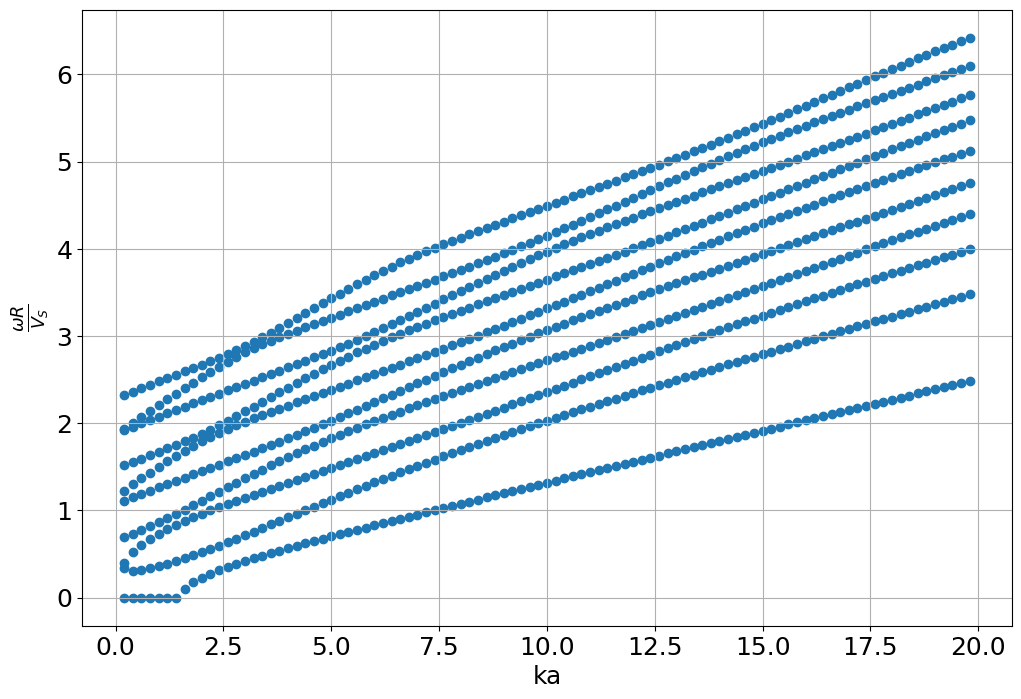

In [6]:
#%matplotlib notebook
plt.figure(figsize=(12,8))
plt.scatter(KP,roots)
plt.grid(True)
plt.xlabel('ka')
plt.ylabel(r'$\frac{\omega R}{V_S}$')

In [7]:
roots = np.array(roots)
KPvals = np.unique(KP)
if number_of_roots > 1:    
    ROOTS = roots.reshape((len(KPvals),number_of_roots))
    KPvals = KPvals#[1:]
else:
    ROOTS = roots    

# Plot the dispersion curves 

In [8]:
k_ = KPvals
w_ = ROOTS*radius/cS

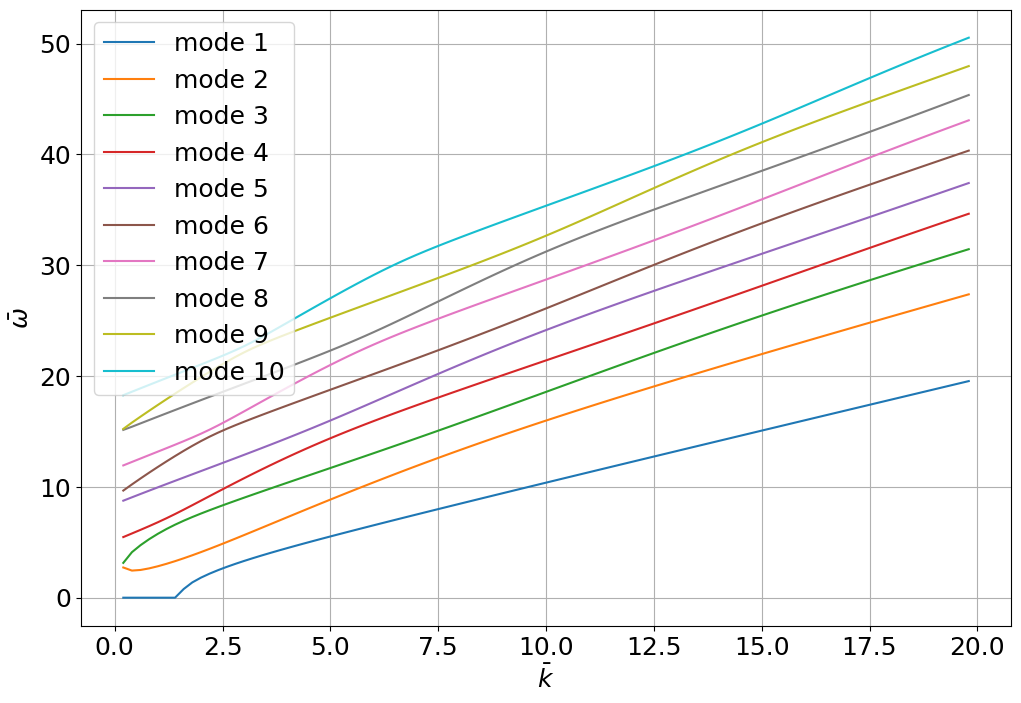

In [9]:
if number_of_roots ==1:
    plt.figure(figsize=(12,8))
    # plt.plot(KPvals,ROOTS, label = 'mode 1')
    plt.plot(k_,w_, label = 'mode 1')
    plt.xlabel('kp')
    plt.ylabel(r'$\omega$ (x 1e6)')
    #plt.axis([1.0,np.max(KP),0,np.max(roots)])
    plt.legend()
    plt.grid(True)
else:
    plt.figure(figsize=(12,8))    
    plt.plot(k_,w_[:,0], label = 'mode 1')
    plt.plot(k_,w_[:,1], label = 'mode 2')
    plt.plot(k_,w_[:,2], label = 'mode 3')
    plt.plot(k_,w_[:,3], label = 'mode 4')
    plt.plot(k_,w_[:,4], label = 'mode 5')
    plt.plot(k_,w_[:,5], label = 'mode 6')
    plt.plot(k_,w_[:,6], label = 'mode 7')
    plt.plot(k_,w_[:,7], label = 'mode 8')
    plt.plot(k_,w_[:,8], label = 'mode 9')
    plt.plot(k_,w_[:,9], label = 'mode 10')
    plt.xlabel(r'$\bar{k}$')
    plt.ylabel(r'$\bar{\omega}$')
    #plt.axis([1.0,np.max(KP),0,np.max(roots)])
    plt.legend()
    plt.grid(True)

(np.float64(0.0), np.float64(19.8), np.float64(0.0), np.float64(8000.0))

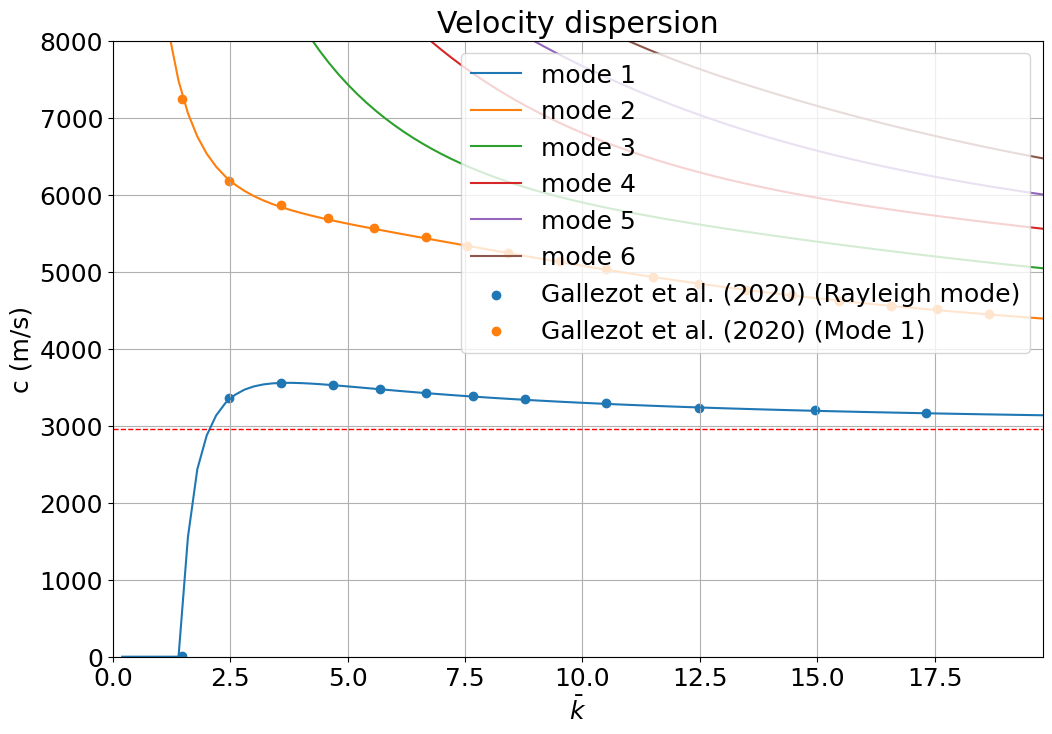

In [10]:
if number_of_roots ==1:
    mode1 = 1000*w_*cS/k_
    plt.figure(figsize=(12,8))
    plt.title('Velocity dispersion')
    plt.plot(KPvals, mode1, label = 'mode 1')
    plt.xlabel('kp')
    plt.ylabel('c (m/s)')
    plt.axis([0.0,np.max(KP),0, 8000.0])
    plt.legend()
    plt.grid(True)
else:
    
    mode1 = 1000*w_[:,0]*cS/k_
    mode2 = 1000*w_[:,1]*cS/k_
    mode3 = 1000*w_[:,2]*cS/k_
    mode4 = 1000*w_[:,3]*cS/k_
    mode5 = 1000*w_[:,4]*cS/k_
    mode6 = 1000*w_[:,5]*cS/k_

    plt.figure(figsize=(12,8))
    plt.title('Velocity dispersion')
    plt.plot(k_, mode1, label = 'mode 1')
    plt.plot(k_, mode2, label = 'mode 2')
    plt.plot(k_, mode3, label = 'mode 3')
    plt.plot(k_, mode4, label = 'mode 4')
    plt.plot(k_, mode5, label = 'mode 5')
    plt.plot(k_, mode6, label = 'mode 6')
    plt.axhline(cR*1000,lw=1.0,ls='--',c='r')
    plt.xlabel(r'$\bar{k}$')
    plt.ylabel('c (m/s)')
    plt.axis([0.0,np.max(KP),0, 8000.0])
    plt.legend()
    plt.grid(True)

ka, Vph = np.loadtxt('Steel_Sphere_Gallezot2020.csv',delimiter=',', unpack=True, skiprows=1)
ka1, Vph1 = np.loadtxt('Steel_Sphere_Gallezot2020_Mode1.csv',delimiter=',', unpack=True, skiprows=1)
plt.scatter(ka, Vph, label = 'Gallezot et al. (2020) (Rayleigh mode)')
plt.scatter(ka1, Vph1, c='tab:orange', label = 'Gallezot et al. (2020) (Mode 1)')
plt.legend(loc = 'upper right')
plt.axis([0.0,np.max(KP),0, 8000.0])

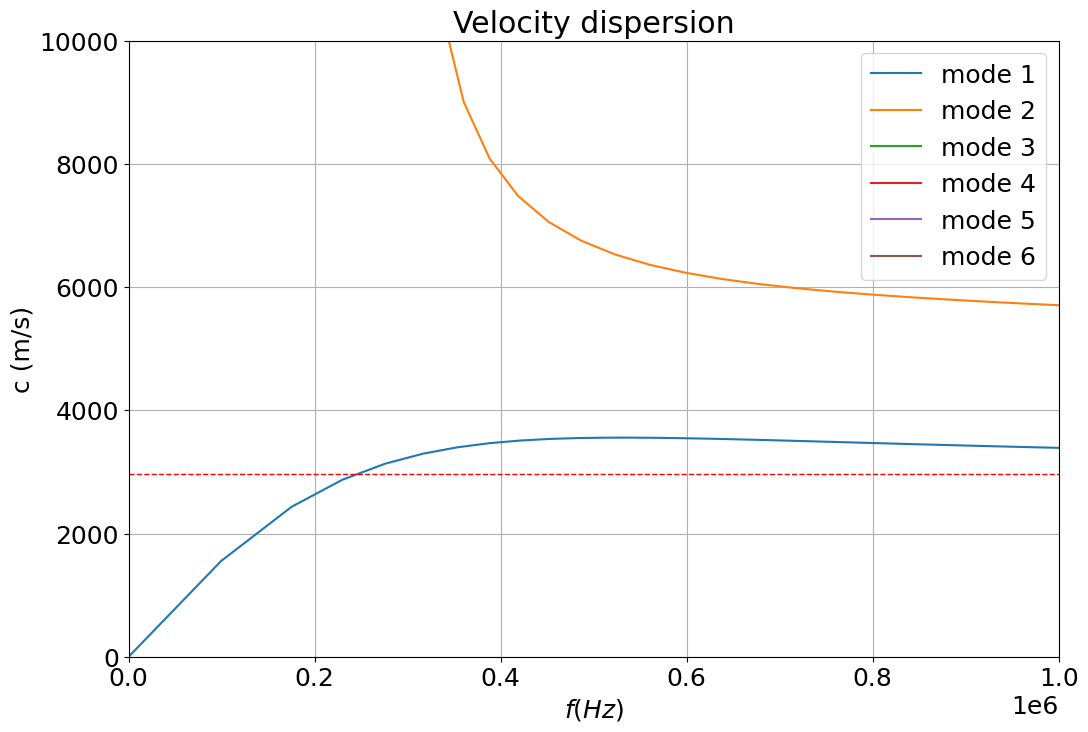

In [11]:
# w_ = w*R/cS -> w = cS*w_/R 
plt.figure(figsize=(12,8))
plt.title('Velocity dispersion')
plt.plot(1e6*cS*w_[:,0]/radius, mode1, label = 'mode 1')
plt.plot(1e6*cS*w_[:,1]/radius, mode2, label = 'mode 2')
plt.plot(1e6*cS*w_[:,2]/radius, mode3, label = 'mode 3')
plt.plot(1e6*cS*w_[:,3]/radius, mode4, label = 'mode 4')
plt.plot(1e6*cS*w_[:,4]/radius, mode5, label = 'mode 5')
plt.plot(1e6*cS*w_[:,5]/radius, mode6, label = 'mode 6')
plt.axhline(cR*1000,lw=1.0,ls='--',c='r')
plt.xlabel(r'$f (Hz)$')
plt.ylabel('c (m/s)')
plt.axis([0.0,f,0, 10000.0])
plt.legend()
plt.grid(True)

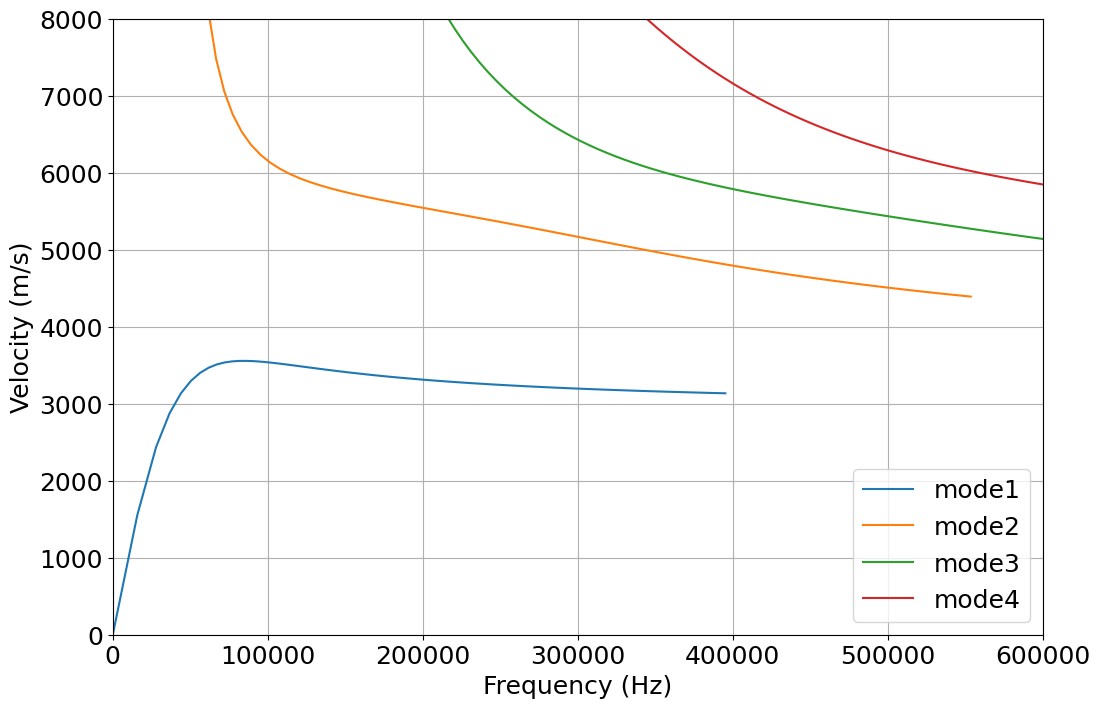

In [12]:
plt.figure(figsize=(12,8))
plt.plot(1e6*cS*w_[:,0]/(2*np.pi*radius), mode1, label = 'mode1')
plt.plot(1e6*cS*w_[:,1]/(2*np.pi*radius), mode2, label = 'mode2')
plt.plot(1e6*cS*w_[:,2]/(2*np.pi*radius), mode3, label = 'mode3')
plt.plot(1e6*cS*w_[:,3]/(2*np.pi*radius), mode4, label = 'mode4')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Velocity (m/s)')
plt.axis([0.0,600000,0, 8000.0])
plt.legend()
plt.grid(True)

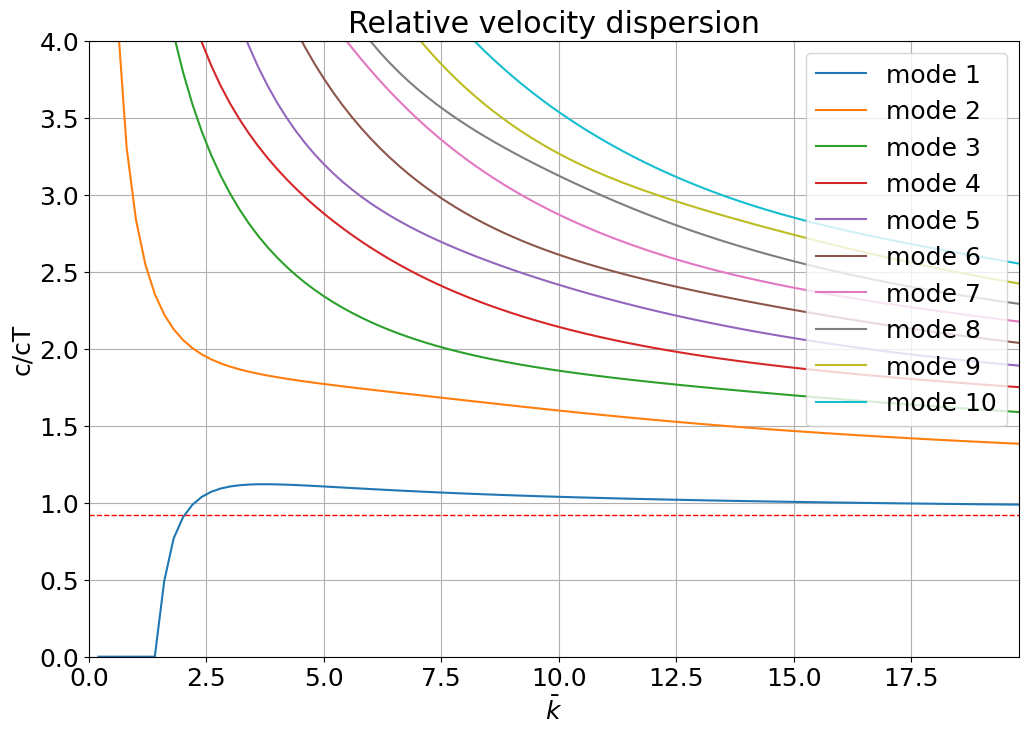

In [13]:
if number_of_roots ==1:
    mode1 = w_/k_#[1:]
    plt.figure(figsize=(12,8))
    plt.title('Relative velocity dispersion')
    plt.plot(k_, mode1, label = 'mode 1')
    plt.xlabel(r'$\bar{k}$')
    plt.ylabel('c/cT')
    plt.axis([0.0,np.max(k_),0, 4.0])
    plt.legend()
    plt.grid(True)
else:
    mode1 = w_[:,0]/k_
    mode2 = w_[:,1]/k_
    mode3 = w_[:,2]/k_
    mode4 = w_[:,3]/k_
    mode5 = w_[:,4]/k_
    mode6 = w_[:,5]/k_
    mode7 = w_[:,6]/k_
    mode8 = w_[:,7]/k_
    mode9 = w_[:,8]/k_
    mode10 = w_[:,9]/k_    
   
    plt.figure(figsize=(12,8))
    plt.title('Relative velocity dispersion')
    plt.plot(k_, mode1, label = 'mode 1')
    plt.plot(k_, mode2, label = 'mode 2')
    plt.plot(k_, mode3, label = 'mode 3')
    plt.plot(k_, mode4, label = 'mode 4')
    plt.plot(k_, mode5, label = 'mode 5')
    plt.plot(k_, mode6, label = 'mode 6')
    plt.plot(k_, mode7, label = 'mode 7')
    plt.plot(k_, mode8, label = 'mode 8')
    plt.plot(k_, mode9, label = 'mode 9')
    plt.plot(k_, mode10, label = 'mode 10')
    plt.axhline(0.9214,lw=1.0,ls='--',c='r')
    plt.xlabel(r'$\bar{k}$')
    plt.ylabel('c/cT')
    plt.axis([0.0,np.max(k_),0, 4.0])
    plt.legend(loc = 'upper right')
    plt.grid(True)